Chapter 16 -  Model Diagnostics

In [8]:
import pandas as pd

housing = pd.read_csv('C:/Users/franj/notebooks/pandas for everyone/pandas-for-everyone/data/housing_renamed.csv')

print(housing.head())

  neighborhood            type  units  year_built   sq_ft    income  \
0    FINANCIAL  R9-CONDOMINIUM     42      1920.0   36500   1332615   
1    FINANCIAL  R4-CONDOMINIUM     78      1985.0  126420   6633257   
2    FINANCIAL  RR-CONDOMINIUM    500         NaN  554174  17310000   
3    FINANCIAL  R4-CONDOMINIUM    282      1930.0  249076  11776313   
4      TRIBECA  R4-CONDOMINIUM    239      1985.0  219495  10004582   

   income_per_sq_ft  expense  expense_per_sq_ft  net_income     value  \
0             36.51   342005               9.37      990610   7300000   
1             52.47  1762295              13.94     4870962  30690000   
2             31.24  3543000               6.39    13767000  90970000   
3             47.28  2784670              11.18     8991643  67556006   
4             45.58  2783197              12.68     7221385  54320996   

   value_per_sq_ft       boro  
0           200.00  Manhattan  
1           242.76  Manhattan  
2           164.15  Manhattan  
3     

In [9]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

house1 = smf.glm("value_per_sq_ft ~ units + sq_ft + boro", data=housing).fit()

print(house1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        value_per_sq_ft   No. Observations:                 2626
Model:                            GLM   Df Residuals:                     2619
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          1879.5
Method:                          IRLS   Log-Likelihood:                -13621.
Date:                Thu, 27 Mar 2025   Deviance:                   4.9224e+06
Time:                        18:39:41   Pearson chi2:                 4.92e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7772
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                43.29

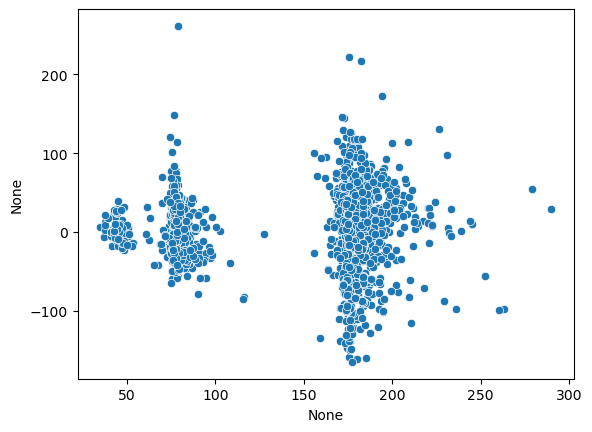

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.scatterplot(x=house1.fittedvalues, y=house1.resid_deviance, ax=ax)

plt.show()

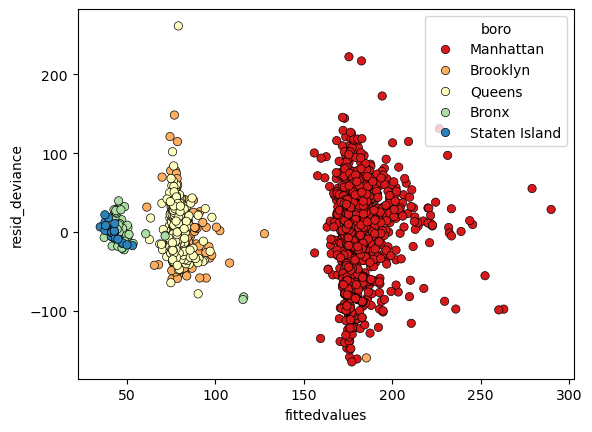

In [11]:
# get the data used for the residual plot and boro color
res_df = pd.DataFrame({'fittedvalues': house1.fittedvalues, 'resid_deviance': house1.resid_deviance, 'boro': housing['boro']})

# greyscale friendly color palette
color_dict = dict(
    {
        "Manhattan": "#d7191c",
        "Brooklyn": "#fdae61",
        "Queens": "#ffffbf",
        "Bronx": "#abdda4",
        "Staten Island": "#2b83ba",
    }
)

fig, ax = plt.subplots()
fig = sns.scatterplot(
    x="fittedvalues",
    y="resid_deviance",
    data=res_df,
    hue="boro",
    ax=ax,
    palette=color_dict,
    edgecolor='black',
)

plt.show()

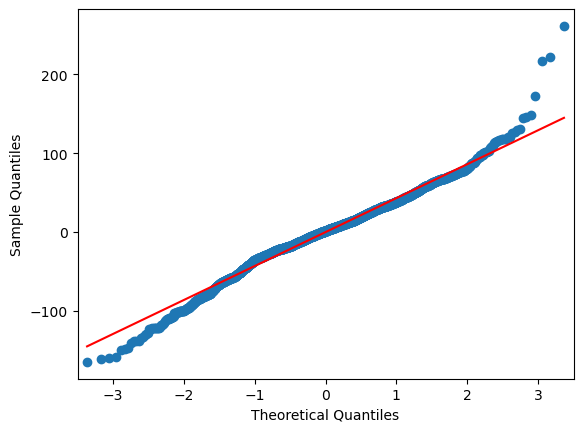

In [12]:
# q-q plots
from scipy import stats

resid = house1.resid_deviance.copy()

fig = statsmodels.graphics.gofplots.qqplot(resid, line='r')
plt.show()

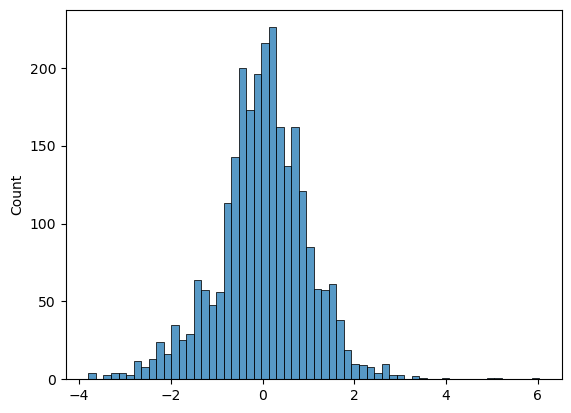

In [13]:
resid_std = stats.zscore(resid)

fig, ax = plt.subplots()
sns.histplot(resid_std, ax=ax)

plt.show()

In [14]:
# comparing multiple models
f1 = 'value_per_sq_ft ~ units + sq_ft + boro'
f2 = 'value_per_sq_ft ~ units * sq_ft + boro'
f3 = 'value_per_sq_ft ~ units + sq_ft *boro + type'
f4 = 'value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type'
f5 = 'value_per_sq_ft ~ boro + type'

house1 = smf.ols(f1, data=housing).fit()
house2 = smf.ols(f2, data=housing).fit()
house3 = smf.ols(f3, data=housing).fit()
house4 = smf.ols(f4, data=housing).fit()
house5 = smf.ols(f5, data=housing).fit()

In [15]:
mod_results = (
    pd.concat(
        [
            house1.params,
            house2.params,
            house3.params,
            house4.params,
            house5.params,
        ],
        axis=1,
    )
    .rename(columns=lambda x: "house" + str(x + 1))
    .reset_index()
    .rename(columns={"index": "param"})
    .melt(id_vars="param", var_name="model", value_name="estimate")
)

print(mod_results)

                           param   model    estimate
0                      Intercept  house1   43.290863
1               boro[T.Brooklyn]  house1   34.562150
2              boro[T.Manhattan]  house1  130.992363
3                 boro[T.Queens]  house1   32.993674
4          boro[T.Staten Island]  house1   -3.630251
..                           ...     ...         ...
85          sq_ft:boro[T.Queens]  house5         NaN
86   sq_ft:boro[T.Staten Island]  house5         NaN
87  sq_ft:type[T.R4-CONDOMINIUM]  house5         NaN
88  sq_ft:type[T.R9-CONDOMINIUM]  house5         NaN
89  sq_ft:type[T.RR-CONDOMINIUM]  house5         NaN

[90 rows x 3 columns]


In [16]:
color_dict = dict(
    {
        "house1": "#d7191c",
        "house2": "#fdae61",
        "house3": "#ffffbf",
        "house4": "#abdda4",
        "house5": "#2b83ba",
    }
)

C:\Users\franj\AppData\Local\Temp\ipykernel_21820\1668772480.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(


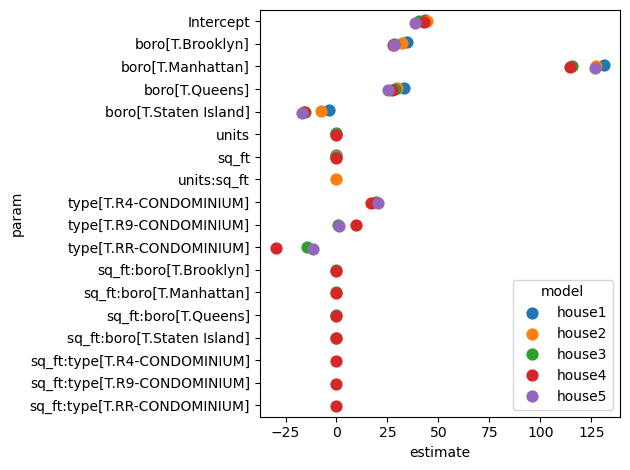

In [17]:
fig, ax = plt.subplots()
ax = sns.pointplot(
    x="estimate",
    y="param",
    hue="model",
    data=mod_results,
    dodge=True,
    join=False,
)

plt.tight_layout()
plt.show()

In [18]:
model_names = ["house1", "house2", "house3", "house4", "house5"]
house_anova = statsmodels.stats.anova.anova_lm(house1, house2, house3, house4, house5)

house_anova.index = model_names

print(house_anova)

        df_resid           ssr  df_diff        ss_diff          F  \
house1    2619.0  4.922389e+06      0.0            NaN        NaN   
house2    2618.0  4.884872e+06      1.0   37517.437605  20.039049   
house3    2612.0  4.619926e+06      6.0  264945.539994  23.585728   
house4    2609.0  4.576671e+06      3.0   43255.441192   7.701289   
house5    2618.0  4.901463e+06     -9.0 -324791.847907  19.275539   

              Pr(>F)  
house1           NaN  
house2  7.912333e-06  
house3  2.754431e-27  
house4  4.025581e-05  
house5           NaN  


In [19]:
house_models = [house1, house2, house3, house4, house5]

abic = pd.DataFrame(
    {
        "model": model_names,
        "aic": [mod.aic for mod in house_models],
        "bic": [mod.bic for mod in house_models],
    }
)

print(abic.sort_values(by=["aic", "bic"]))

    model           aic           bic
3  house4  27084.800043  27184.644733
2  house3  27103.502577  27185.727615
1  house2  27237.939618  27284.925354
4  house5  27246.843392  27293.829128
0  house1  27256.031113  27297.143632


In [20]:
def deviance_table(*models):
    """Create a table of model diagnostics from model objects"""
    return pd.DataFrame(
        {
            "df_residuals": [mod.df_resid for mod in models],
            "resid_stddev": [mod.deviance for mod in models],
            "df": [mod.df_model for mod in models],
            "deviance": [mod.deviance for mod in models],
        }
    )

f1 = 'value_per_sq_ft ~ units + sq_ft + boro'
f2 = 'value_per_sq_ft ~ units * sq_ft + boro'
f3 = 'value_per_sq_ft ~ units + sq_ft * boro + type'
f4 = 'value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type'
f5 = 'value_per_sq_ft ~ boro + type'

glm1 = smf.glm(f1, data=housing).fit()
glm2 = smf.glm(f2, data=housing).fit()
glm3 = smf.glm(f3, data=housing).fit()
glm4 = smf.glm(f4, data=housing).fit()
glm5 = smf.glm(f5, data=housing).fit()

glm_anova = deviance_table(glm1, glm2, glm3, glm4, glm5)
print(glm_anova)

   df_residuals  resid_stddev  df      deviance
0          2619  4.922389e+06   6  4.922389e+06
1          2618  4.884872e+06   7  4.884872e+06
2          2612  4.619926e+06  13  4.619926e+06
3          2609  4.576671e+06  16  4.576671e+06
4          2618  4.901463e+06   7  4.901463e+06


In [21]:
# create a binary variable
housing["high"] = (housing["value_per_sq_ft"] >= 150).astype(int)

print(housing["high"].value_counts())

high
0    1619
1    1007
Name: count, dtype: int64


In [22]:
# create and fit our logistic regression using GLM
f1 = "high ~ units + sq_ft + boro"
f2 = "high ~ units * sq_ft + boro"
f3 = "high ~ units + sq_ft * boro + type"
f4 = "high ~ units + sq_ft * boro + sq_ft * type"
f5 = "high ~ boro + type"

logistic = statsmodels.genmod.families.family.Binomial(
    link=statsmodels.genmod.families.links.Logit()
)

glm1 = smf.glm(f1, data=housing, family=logistic).fit()
glm2 = smf.glm(f2, data=housing, family=logistic).fit()
glm3 = smf.glm(f3, data=housing, family=logistic).fit()
glm4 = smf.glm(f4, data=housing, family=logistic).fit()
glm5 = smf.glm(f5, data=housing, family=logistic).fit()

# show the deviances from our GLM models
print(deviance_table(glm1, glm2, glm3, glm4, glm5))

   df_residuals  resid_stddev  df     deviance
0          2619   1695.631547   6  1695.631547
1          2618   1686.126740   7  1686.126740
2          2612   1636.492830  13  1636.492830
3          2609   1619.431515  16  1619.431515
4          2618   1666.615696   7  1666.615696


In [23]:
mods = [glm1, glm2, glm3, glm4, glm5]

abic_glm = pd.DataFrame(
    {
        "model": model_names,
        "aic": [mod.aic for mod in house_models],
        "bic": [mod.bic for mod in house_models],
    }
)

print(abic_glm.sort_values(by=["aic", "bic"]))

    model           aic           bic
3  house4  27084.800043  27184.644733
2  house3  27103.502577  27185.727615
1  house2  27237.939618  27284.925354
4  house5  27246.843392  27293.829128
0  house1  27256.031113  27297.143632


In [24]:
# k fold cross validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print(housing.columns)

Index(['neighborhood', 'type', 'units', 'year_built', 'sq_ft', 'income',
       'income_per_sq_ft', 'expense', 'expense_per_sq_ft', 'net_income',
       'value', 'value_per_sq_ft', 'boro', 'high'],
      dtype='object')


In [25]:
# get training and test data
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(
        housing[["units", "sq_ft", "boro"]], drop_first=True
    ),

    housing["value_per_sq_ft"],
    test_size=0.20,
    random_state=42,
)

In [26]:
lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.6137125285030869


In [27]:
from patsy import dmatrices

y, X = dmatrices(
    "value_per_sq_ft ~ units + sq_ft + boro",
    housing,
    return_type="dataframe",
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.6137125285034691


In [28]:
from sklearn.model_selection import KFold, cross_val_score

# get a fresh new housing data set
housing = pd.read_csv('data/housing_renamed.csv')

In [29]:
kf = KFold(n_splits=5)

y, X = dmatrices('value_per_sq_ft ~ units + sq_ft + boro', housing)

In [30]:
coefs = []
scores = []
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    lr = LinearRegression().fit(X_train, y_train)
    coefs.append(pd.DataFrame(lr.coef_))
    scores.append(lr.score(X_test, y_test))

In [31]:
coefs_df = pd.concat(coefs)
coefs_df.columns = X.design_info.column_names
print(coefs_df)

   Intercept  boro[T.Brooklyn]  boro[T.Manhattan]  boro[T.Queens]  \
0        0.0         33.369037         129.904011       32.103100   
0        0.0         32.889925         116.957385       31.295956   
0        0.0         30.975560         141.859327       32.043449   
0        0.0         41.449196         130.779013       33.050968   
0        0.0        -38.511915          56.069855      -17.557939   

   boro[T.Staten Island]     units     sq_ft  
0              -4.381085 -0.205890  0.000220  
0              -4.919232 -0.146180  0.000155  
0              -4.379916 -0.179671  0.000194  
0              -3.430209 -0.207904  0.000232  
0               0.000000 -0.145829  0.000202  


In [32]:
import numpy as np

print(coefs_df.apply(np.mean))

Intercept                  0.000000
boro[T.Brooklyn]          20.034361
boro[T.Manhattan]        115.113918
boro[T.Queens]            22.187107
boro[T.Staten Island]     -3.422088
units                     -0.177095
sq_ft                      0.000201
dtype: float64


In [33]:
print(scores)

[0.02731416290936839, -0.5538362212186871, -0.15636371688032158, -0.3234202061860081, -1.6929655586236945]


In [34]:
# use cross_val_scores to calculate CV scores
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5)
print(scores)

[ 0.02731416 -0.55383622 -0.15636372 -0.32342021 -1.69296556]


In [35]:
print(scores.mean())

-0.5398543079998686


In [36]:
# create the predictor and response matrices
y1, X1 = dmatrices("value_per_sq_ft ~ units + sq_ft + boro", housing)

y2, X2 = dmatrices("value_per_sq_ft ~ units*sq_ft + boro", housing)

y3, X3 = dmatrices("value_per_sq_ft ~ units + sq_ft* boro + type", housing)

y4, X4 = dmatrices("value_per_sq_ft ~ units + sq_ft*boro + sq_ft* type", housing)

y5, X5 = dmatrices("value_per_sq_ft ~ boro + type", housing)

# fit our models
model = LinearRegression()

scores1 = cross_val_score(model, X1, y1, cv=5)
scores2 = cross_val_score(model, X2, y2, cv=5)
scores3 = cross_val_score(model, X3, y3, cv=5)
scores4 = cross_val_score(model, X4, y4, cv=5)
scores5 = cross_val_score(model, X5, y5, cv=5)

In [37]:
scores_df = pd.DataFrame(
    [scores1, scores2, scores3, scores4, scores5]
)

print(scores_df.apply(np.mean, axis=1))

0   -0.539854
1   -1.088184
2   -0.482317
3   -0.550043
4   -0.507196
dtype: float64
